In [344]:
import nltk
import string
import re
import numpy as np
import pandas as pd
import sklearn
from nltk.corpus import stopwords, twitter_samples
import seaborn as sns
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix,f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics
from sklearn import metrics
from unidecode import unidecode
from collections import Counter
from sklearn.svm import LinearSVC, SVC
import gensim
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers.convolutional import Conv1D   
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import warnings

>### Step 1: Reading in data

In [287]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [288]:
train_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [289]:
train_data["Processed_text"] = train_data["text"]
test_data["Processed_text"] = test_data["text"]

train_data['Length_Before_Processing'] = train_data['text'].apply(len)
test_data['Length_Before_Processing'] = train_data['text'].apply(len)
test_data

,id,keyword,location,text,Processed_text,Length_Before_Processing
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash,69
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","Heard about #earthquake is different cities, s...",38
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","there is a forest fire at spot pond, geese are...",133
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. #Spokane #wildfires,65
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,88
...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,102
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,Storm in RI worse than last hurricane. My city...,130
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,Green Line derailment in Chicago http://t.co/U...,64
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,MEG issues Hazardous Weather Outlook (HWO) htt...,123


In [290]:
null_val_sum = train_data.isnull().sum()
duplicate = train_data[train_data.duplicated()].shape[0]
pd.DataFrame({"Column": null_val_sum.index, "Number of Null Values": null_val_sum.values,
              "Number of Duplicate Values":duplicate, "Proportion": null_val_sum.values / len(train_data), "Data Type": train_data.dtypes })

,Column,Number of Null Values,Number of Duplicate Values,Proportion,Data Type
id,id,0,0,0.000000,int64
keyword,keyword,61,0,0.008013,object
location,location,2533,0,0.332720,object
text,text,0,0,0.000000,object
target,target,0,0,0.000000,int64
Processed_text,Processed_text,0,0,0.000000,object
Length_Before_Processing,Length_Before_Processing,0,0,0.000000,int64


In [291]:
train_data.dropna(subset=['keyword'], inplace=True)
train_data.dropna(subset=['location'], inplace=True)
train_data.reset_index(drop=True, inplace=True)

In [292]:
null_val_sum = train_data.isnull().sum()
duplicate = train_data[train_data.duplicated()].shape[0]
pd.DataFrame({"Column": null_val_sum.index, "Number of Null Values": null_val_sum.values,
              "Number of Duplicate Values":duplicate, "Proportion": null_val_sum.values / len(train_data), "Data Type": train_data.dtypes })

,Column,Number of Null Values,Number of Duplicate Values,Proportion,Data Type
id,id,0,0,0.0,int64
keyword,keyword,0,0,0.0,object
location,location,0,0,0.0,object
text,text,0,0,0.0,object
target,target,0,0,0.0,int64
Processed_text,Processed_text,0,0,0.0,object
Length_Before_Processing,Length_Before_Processing,0,0,0.0,int64


In [293]:
null_val_sum1 = test_data.isnull().sum()
duplicate1 = test_data[test_data.duplicated()].shape[0]
pd.DataFrame({"Column": null_val_sum1.index, "Number of Null Values": null_val_sum1.values,
              "Number of Duplicate Values":duplicate1, "Proportion": null_val_sum1.values / len(test_data), "Data Type": test_data.dtypes })

,Column,Number of Null Values,Number of Duplicate Values,Proportion,Data Type
id,id,0,0,0.000000,int64
keyword,keyword,26,0,0.007968,object
location,location,1105,0,0.338645,object
text,text,0,0,0.000000,object
Processed_text,Processed_text,0,0,0.000000,object
Length_Before_Processing,Length_Before_Processing,0,0,0.000000,int64


In [294]:
test_data.dropna(subset=['keyword'], inplace=True)
test_data.dropna(subset=['location'], inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [295]:
null_val_sum1 = test_data.isnull().sum()
duplicate1 = test_data[test_data.duplicated()].shape[0]
pd.DataFrame({"Column": null_val_sum1.index, "Number of Null Values": null_val_sum1.values,
              "Number of Duplicate Values":duplicate1, "Proportion": null_val_sum1.values / len(test_data), "Data Type": test_data.dtypes })

,Column,Number of Null Values,Number of Duplicate Values,Proportion,Data Type
id,id,0,0,0.0,int64
keyword,keyword,0,0,0.0,object
location,location,0,0,0.0,object
text,text,0,0,0.0,object
Processed_text,Processed_text,0,0,0.0,object
Length_Before_Processing,Length_Before_Processing,0,0,0.0,int64


In [296]:
train_data

,id,keyword,location,text,target,Processed_text,Length_Before_Processing
0,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,@bbcmtd Wholesale Markets ablaze http://t.co/l...,55
1,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,We always try to bring the heavy. #metal #RT h...,67
2,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,#AFRICANBAZE: Breaking news:Nigeria flag set a...,82
3,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,Crying out for more! Set me ablaze,34
4,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,76
...,...,...,...,...,...,...,...
5075,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0,On the bright side I wrecked http://t.co/uEa0t...,51
5076,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0,@widda16 ... He's gone. You can relax. I thoug...,107
5077,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,Three days off from work and they've pretty mu...,107
5078,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,#FX #forex #trading Cramer: Iger's 3 words tha...,93


>### Pre-processing Data

In [297]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    cleaned_text = ' '.join(lemmatized_tokens)
    return cleaned_text

In [298]:
train_data['Processed_text'] = train_data['Processed_text'].apply(clean_text)
test_data['Processed_text'] = test_data['Processed_text'].apply(clean_text)

# Split the data into features and target variable
#X = train_data[['keyword', 'Processed_text']]
#y = train_data['target']

In [299]:
train_data

,id,keyword,location,text,target,Processed_text,Length_Before_Processing
0,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,bbcmtd wholesale market ablaze,55
1,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,always try bring heavy metal rt,67
2,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze breaking newsnigeria flag set abla...,82
3,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,cry set ablaze,34
4,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus side look sky last night ablaze,76
...,...,...,...,...,...,...,...
5075,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0,bright side wrecked,51
5076,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0,widda he gone relax thought wife wrecked cake ...,107
5077,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,three day work theyve pretty much wrecked haha...,107
5078,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,fx forex trading cramer igers word wrecked dis...,93


>### Handling Diacritics

In [300]:
def diacriticsHandler(text):
    text = unidecode(text)
    return text

>### Removing HTML

In [301]:
def remove_html_tags(text):
    clean_text = re.sub('<.*?>', '', text)
    return clean_text
def remove_urls(text):
    clean_text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    return clean_text

In [302]:
train_data['Processed_text'] = train_data['Processed_text'].apply(remove_html_tags)
test_data['Processed_text'] = test_data['Processed_text'].apply(remove_html_tags)


train_data['Processed_text'] = train_data['Processed_text'].apply(remove_urls)
test_data['Processed_text'] = test_data['Processed_text'].apply(remove_urls)

train_data['Processed_text'] = train_data['Processed_text'].apply(diacriticsHandler)
test_data['Processed_text'] = test_data['Processed_text'].apply(diacriticsHandler)

In [303]:
test_data['Processed_text']

0       birmingham wholesale market ablaze bbc news fi...
1                   sunkxssedharry wear short race ablaze
2       previouslyondoyintv toke makinwas marriage cri...
3                                              check nsfw
4       psa im splitting personality techie follow abl...
                              ...                        
2153    yakuboobs think deactivated notification aid t...
2154    rt cnbc word disney ceo bob iger wrecked disne...
2155    smackdown tyme put good mood since got wrecked...
2156    thrillhho jsyk havent stopped thinking abt rem...
2157    stighefootball begovic garbage got wrecked red...
Name: Processed_text, Length: 2158, dtype: object

>### Text cleaning : Tokenization, Removal of stop words, Removal of digits and Removal of punctutations

In [304]:
def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # Tokenization of the text
    tokenized = word_tokenize(text)
    
    # Create an instance of stemming
    stemmer = PorterStemmer()
    
    text_ = []
    
    for word in tokenized:
        if word.lower() not in stopwords.words('english'):
            stem_word = stemmer.stem(word)
            text_.append(stem_word)
    
    return text_

In [305]:
train_data['Processed_text'] = train_data['Processed_text'].apply(preprocess_text)
test_data['Processed_text'] = test_data['Processed_text'].apply(preprocess_text)

In [306]:
train_data['Processed_text']

0                       [bbcmtd, wholesal, market, ablaz]
1                   [alway, tri, bring, heavi, metal, rt]
2       [africanbaz, break, newsnigeria, flag, set, ab...
3                                       [cri, set, ablaz]
4              [plu, side, look, sky, last, night, ablaz]
                              ...                        
5075                                [bright, side, wreck]
5076    [widda, gone, relax, thought, wife, wreck, cak...
5077    [three, day, work, theyv, pretti, much, wreck,...
5078    [fx, forex, trade, cramer, iger, word, wreck, ...
5079    [enginesh, great, atmospher, british, lion, gi...
Name: Processed_text, Length: 5080, dtype: object

>## Bag of Words Feature Extraction

In [307]:
texttr = train_data['Processed_text'].values
textte = test_data['Processed_text'].values

y = train_data['target']

In [308]:
def get_list(data):
    vocab = []
    
    for list_of_words in data:
        for word in list_of_words:
            if word not in vocab:
                vocab.append(word)

    return vocab

list_tr = get_list(texttr)
list_te = get_list(textte)


In [309]:
def Extractfeature(text, list_):
    sent_vec = []
    for token in list_:
        if token in text:
            sent_vec.append(text.count(token))
        else:
            sent_vec.append(0)
        
    return sent_vec


feature_train = []
feature_test = []

for i in texttr:
    feature_train.append(Extractfeature(i,list_tr))
    
for j in textte:
    feature_test.append(Extractfeature(j,list_te))
    
feature_train = np.array(feature_train)
feature_test = np.array(feature_test)

feature_test

array([[2, 2, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

>## Modelling

In [310]:
def accuracy(y_true,y_pred):
    #calculating the accuracy
    acc = np.sum(y_true==y_pred)/len(y_true)
    #This is RootMean Square Error .which is to find out the error ratio of models
    RMSE = np.sqrt(np.square(np.subtract(y_true,y_pred)).mean())
    return acc,RMSE

# Results summarizer function (scores, confusion matrix) for classification results
def Summarizer(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='binary')
    rec = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    
    
    plt.figure(figsize=(7, 7))
    
    sns.heatmap(cm,
                annot=True,
                cmap='Reds',
                xticklabels=labels.values(),
                yticklabels=labels.values()
               ) 
    
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Tweet')
    plt.ylabel('Actual Tweet')
    plt.show()
    
    print(f'Accuracy Score: ' + '{:.4%}'.format(acc))
    print(f'Precision Score: ' + '{:.4%}'.format(prec))
    print(f'Recall Score: ' + '{:.4%}'.format(rec))
    print(f'F_1 Score: ' + '{:.4%}'.format(f1))

In [311]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_train, y, test_size=0.25, random_state=42)

In [312]:
y_train

1803    1
2441    0
3973    1
1295    1
4092    0
       ..
4426    1
466     0
3092    0
3772    1
860     0
Name: target, Length: 3810, dtype: int64

>### Multinomial Naive Bayes model

In [313]:
# Using the Multinomial Naive Bayes model from sklearn
# method fit trains/fits the model, using our training data
model = MultinomialNB()
model.fit(X_train, y_train)

# getting the predictions from the trained model
y_pred = model.predict(X_test)

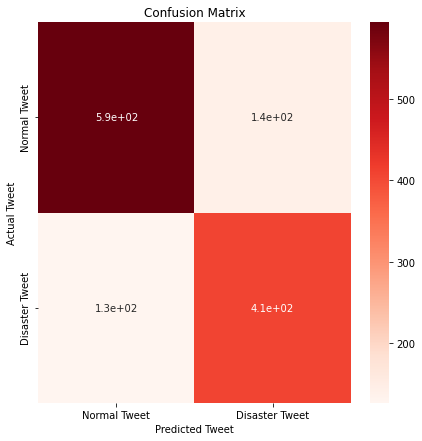

Accuracy Score: 78.8189%
Precision Score: 74.1348%
Recall Score: 76.2172%
F_1 Score: 75.1616%
Mean Squared Error: 0.21181102362204723
Mean Absolute Error: 0.21181102362204723
R-squared: 0.1307655512131577


In [314]:
# Evaluate the model on the testing set
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


Summarizer(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

>### logistic regression model

In [315]:
# Train the logistic regression model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict the test set
y_pred = lr.predict(X_test)

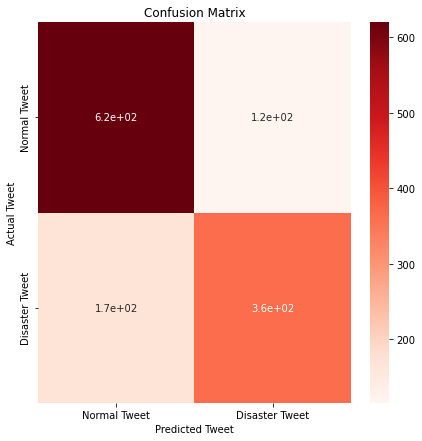

Accuracy Score: 77.4016%
Precision Score: 75.7829%
Recall Score: 67.9775%
F_1 Score: 71.6683%
Mean Squared Error: 0.22598425196850394
Mean Absolute Error: 0.22598425196850394
R-squared: 0.07260116430548802


In [316]:
# Evaluate the model on the testing set
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


Summarizer(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

>### Random Forest Classifier model

In [317]:
# Train the model
rfst = RandomForestClassifier(n_estimators=100, random_state=42)
rfst.fit(X_train, y_train)

# Predict on the testing set and calculate accuracy
y_pred = rfst.predict(X_test)


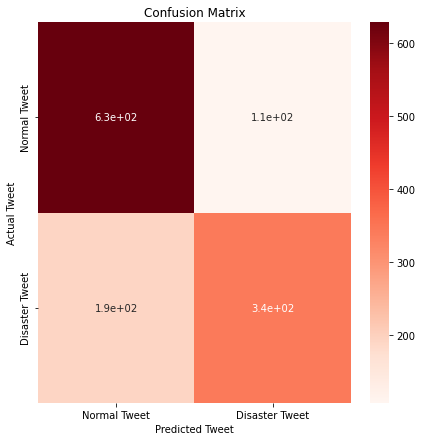

Accuracy Score: 76.5354%
Precision Score: 76.2222%
Recall Score: 64.2322%
F_1 Score: 69.7154%
Mean Squared Error: 0.2346456692913386
Mean Absolute Error: 0.2346456692913386
R-squared: 0.03705626119524541


In [318]:
# Evaluate the model on the testing set
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


Summarizer(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

>## Term Frequency-Inverse Document Frequency (TF-IDF) Modelling

In [319]:
# Split the data into training and testing sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(texttr, y, test_size=0.25, random_state=42)

In [320]:
y_train1

1803    1
2441    0
3973    1
1295    1
4092    0
       ..
4426    1
466     0
3092    0
3772    1
860     0
Name: target, Length: 3810, dtype: int64

In [321]:
# Convert data to a list of strings
documents1 = [' '.join(doc) for doc in X_train1]
documents2 = [' '.join(doc) for doc in X_test1]

# Apply TF-IDF feature extraction
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(documents1)
X_test_tfidf = vectorizer.transform(documents2)


In [322]:
# Print the shape of the feature matrices
print("Training set shape:", X_train_tfidf.shape)
print("Testing set shape:", X_test_tfidf.shape)

Training set shape: (3810, 8875)
Testing set shape: (1270, 8875)


In [323]:
# Train different models
models = [
    LogisticRegression(),
    MultinomialNB(),
    LinearSVC(),
    RandomForestClassifier(),
    # ... Add more models as needed
]

for model in models:
    model.fit(X_train_tfidf, y_train1)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test1, y_pred)
    print(model.__class__.__name__, "Accuracy:", accuracy)

LogisticRegression Accuracy: 0.7913385826771654
MultinomialNB Accuracy: 0.8015748031496063
LinearSVC Accuracy: 0.7763779527559055
RandomForestClassifier Accuracy: 0.7637795275590551


>### Word Embeddings Modellling

In [329]:
# Split the data into train and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(texttr, y, test_size=0.2, random_state=42)

# Train Word2Vec model
model_w2v = gensim.models.Word2Vec(sentences=X_train2, vector_size=100, window=5, min_count=1, workers=4)

# Function to compute the feature vector for a sentence
def compute_sentence_vector(sentence):
    vectors = [model_w2v.wv[word] for word in sentence if word in model_w2v.wv]
    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return []

# Transform the data into word embeddings
X_train_w2v = [compute_sentence_vector(sentence) for sentence in X_train2]
X_test_w2v = [compute_sentence_vector(sentence) for sentence in X_test2]

# Initialize models
models = [
    LogisticRegression(),
    SVC(),
    RandomForestClassifier()
]

# Train and evaluate models
for model in models:
    model.fit(X_train_w2v, y_train2)
    y_pred = model.predict(X_test_w2v)
    accuracy = accuracy_score(y_test2, y_pred)
    precision = precision_score(y_test2, y_pred, average='weighted')
    recall = recall_score(y_test2, y_pred, average='weighted')

    print(model.__class__.__name__)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print()

LogisticRegression
Accuracy: 0.5708661417322834
Precision: 0.5406149824157356
Recall: 0.5708661417322834

SVC
Accuracy: 0.6781496062992126
Precision: 0.6782489006678688
Recall: 0.6781496062992126

RandomForestClassifier
Accuracy: 0.7047244094488189
Precision: 0.7119324093954892
Recall: 0.7047244094488189



>### N-grams Modelling

In [332]:
# Split the data into train and test sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(texttr, y, test_size=0.2, random_state=42)


# Convert data to a list of strings
documents3 = [' '.join(doc) for doc in X_train3]
documents4 = [' '.join(doc) for doc in X_test3]

# Apply N-grams feature extraction
ngram_range = (1, 2)  # Extract unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=ngram_range)
X_train_ngrams = vectorizer.fit_transform(documents3)
X_test_ngrams = vectorizer.transform(documents4)

# Initialize models
models = [
    LogisticRegression(),
    SVC(),
    RandomForestClassifier()
]

# Train and evaluate models
for model in models:
    model.fit(X_train_ngrams, y_train3)
    y_pred3 = model.predict(X_test_ngrams)
    accuracy = accuracy_score(y_test3, y_pred3)
    precision = precision_score(y_test3, y_pred3, average='weighted')
    recall = recall_score(y_test3, y_pred3, average='weighted')
    f1 = f1_score(y_test3, y_pred3, average='weighted')

    print(model.__class__.__name__)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print()

LogisticRegression
Accuracy: 0.7854330708661418
Precision: 0.786766424058279
Recall: 0.7854330708661418
F1 Score: 0.7821747404742097

SVC
Accuracy: 0.7785433070866141
Precision: 0.7967447120901516
Recall: 0.7785433070866141
F1 Score: 0.7683276864894296

RandomForestClassifier
Accuracy: 0.764763779527559
Precision: 0.7739759209650001
Recall: 0.764763779527559
F1 Score: 0.7565234845855229



In [345]:
# Convert labels to numpy arrays
y_train_encoded = np.array(y_train3)
y_test_encoded = np.array(y_test3)

# Deep learning models
models = [
    ('LSTM', Sequential([
        Embedding(input_dim=X_train_ngrams.shape[1], output_dim=100),
        LSTM(128),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])),
    ('CNN', Sequential([
        Embedding(input_dim=X_train_ngrams.shape[1], output_dim=100),
        Conv1D(64, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])),
    ('BiLSTM', Sequential([
        Embedding(input_dim=X_train_ngrams.shape[1], output_dim=100),
        Bidirectional(LSTM(128)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])),
]

# Train and evaluate models
for model_name, model in models:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_ngrams, y_train_encoded, epochs=10, batch_size=32, verbose=1)
    y_pred_proba = model.predict(X_test_ngrams)
    y_pred = (y_pred_proba > 0.5).astype(int)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    precision = precision_score(y_test_encoded, y_pred)
    recall = recall_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred)

    print(model_name)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print()

Epoch 1/10
  9/127 [=>............................] - ETA: 26:37:57 - loss: 0.6908 - accuracy: 0.5382

KeyboardInterrupt: 

In [ ]:
texttr = train_data['text'].values
targettr = train_data['label'].values